In [45]:
import os
import email
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from os import path
import re
import csv
import tensorflow as tf
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu
from sklearn.utils import shuffle
import nltk
import random
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
from multiprocessing import  Pool
from nltk.corpus import reuters


In [46]:
df = pd.read_csv('emails.csv')

df = df.sample(frac=0.35, random_state=42)
df.reset_index(inplace = True, drop = True)

In [72]:
df = df.head(20)

In [73]:
def get_message(message):
    ans = []
    for msg in message:
        main_msg = msg
        process_msg = email.message_from_string(main_msg)
        ans.append(process_msg.get_payload())
    return ans

In [74]:
df['content'] = get_message(df['message'])

In [75]:
content = df['content'].str.replace("\n"," ")
content = content.apply(lambda x : re.sub('[^A-Za-z0-9]+',' ',x))
content = content.str.lower()
content = content.str.strip()

In [76]:
df['content'] = content

In [77]:
from nltk.tokenize import word_tokenize

In [78]:
df['tokenize'] = df['content'].apply(word_tokenize)

In [79]:
df['tokenize']

0    [bill, thanks, for, the, info, i, also, spoke,...
1    [aimee, please, check, meter, 1591, lamay, gas...
2    [gcca, crawfish, and, rip, off, raffle, over, ...
3    [keoni, zip, chris, per, your, request, here, ...
4    [i, m, trying, to, change, the, receipt, meter...
Name: tokenize, dtype: object

In [80]:
df['content_len'] = df['content'].apply(lambda x : len(x))

<Axes: xlabel='content_len', ylabel='Count'>

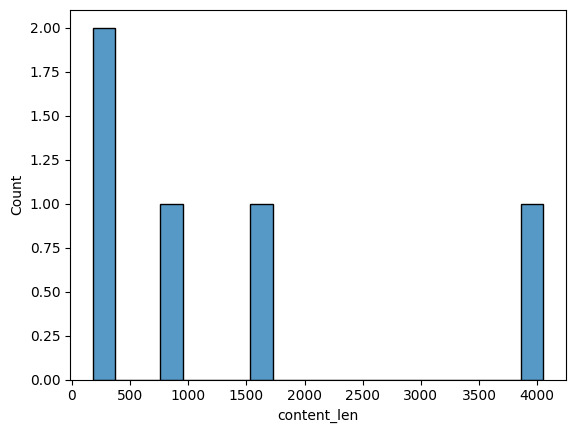

In [81]:
import seaborn as sns
sns.histplot(df['content_len'],bins=20)

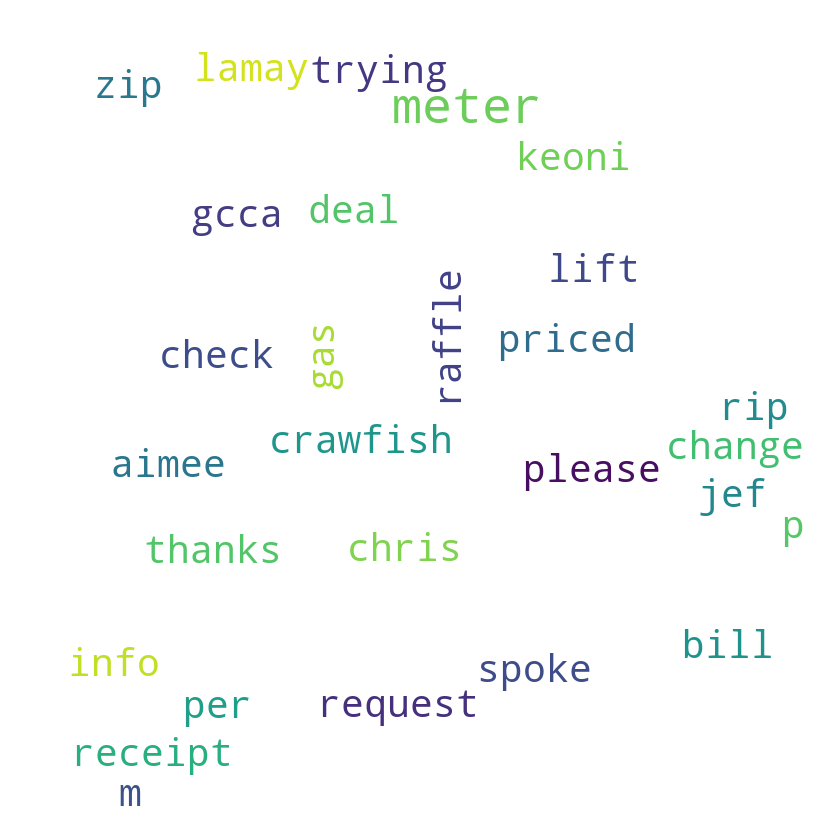

In [82]:
# Word cloud for content , X-TO, X-From
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS ,
                max_font_size = 50,
                min_font_size = 10).generate(df['content'].to_string())
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [91]:
print(df['content'].to_string())

0    bill thanks for the info i also spoke with jef...
1    aimee please check meter 1591 lamay gas lift i...
2    gcca crawfish and rip off raffle over priced p...
3    keoni zip chris per your request here are the ...
4    i m trying to change the receipt meter on deal...


In [94]:
corpus = df['tokenize'].to_list()

In [97]:
corpus

[['bill',
  'thanks',
  'for',
  'the',
  'info',
  'i',
  'also',
  'spoke',
  'with',
  'jeff',
  'about',
  'how',
  'enroncredit',
  'com',
  'ltd',
  'was',
  'going',
  'to',
  'work',
  'since',
  'dennis',
  'o',
  'connell',
  'london',
  'lawyer',
  'is',
  'responsible',
  'for',
  'that',
  'group',
  'maybe',
  'you',
  'will',
  'be',
  'able',
  'to',
  'clarify',
  'which',
  'of',
  'jeff',
  's',
  'positions',
  'will',
  'be',
  'hedges',
  'and',
  'which',
  'will',
  'be',
  'backed',
  'to',
  'enroncredit',
  'maybe',
  'rod',
  'will',
  'be',
  'handling',
  'most',
  'of',
  'jeff',
  's',
  'credit',
  'i',
  'd',
  'appreciate',
  'an',
  'update',
  'sara',
  'william',
  's',
  'bradford',
  '08',
  '29',
  '2000',
  '07',
  '24',
  'am',
  'to',
  'sara',
  'shackleton',
  'hou',
  'ect',
  'ect',
  'cc',
  'mark',
  'taylor',
  'hou',
  'ect',
  'ect',
  'paul',
  'radous',
  'corp',
  'enron',
  'enron',
  'rod',
  'nelson',
  'lon',
  'ect',
  'ect',

In [99]:
bigram_model = defaultdict(lambda : defaultdict(lambda  :0))

In [105]:
for sent in corpus:
    sentence = sent
    n_grams = list(bigrams(sentence,pad_right=True,pad_left=True))
    for word1, word2 in n_grams:
        bigram_model[(word1)][word2]+=1

In [121]:
for w1 in bigram_model:
    word1 = w1
    total = float(sum(bigram_model[w1].values()))
    #print(total)
    for w2 in bigram_model[w1]:
        bigram_model[w1][w2]/=total
        #print(bigram_model[w1],bigram_model[w1][w2],ratio)
        

In [123]:
def get_next_word(model, input_string):
    if len(input_string.split()) > 1:
        input_string_ = input_string.split()
        output = dict(model[tuple(input_string_)])
        return "{} {}".format(input_string,
            list({k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)})[0])
    else:
        input_string = (input_string)
        output = dict(model[input_string])
        return "{} {}".format(input_string,
            list({k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)})[0])

In [130]:
text = get_next_word(bigram_model,'change')

In [140]:
def complete_sentence(model, input_str, count, ngrams=2):
  for i in range(count):
    curr_ngram = input_str.split()[-ngrams+1:]
    curr_ngram = " ".join(curr_ngram)
    nxt_word = get_next_word(model, curr_ngram).split()[-1]

    input_str += ' ' + nxt_word
    #print('Step '+str(i)+' '+input_str)
    print(input_str)



In [141]:
complete_sentence(bigram_model,'since',20,2)

since dennis
since dennis o
since dennis o connell
since dennis o connell london
since dennis o connell london lawyer
since dennis o connell london lawyer is
since dennis o connell london lawyer is the
since dennis o connell london lawyer is the intended
since dennis o connell london lawyer is the intended recipient
since dennis o connell london lawyer is the intended recipient or
since dennis o connell london lawyer is the intended recipient or any
since dennis o connell london lawyer is the intended recipient or any review
since dennis o connell london lawyer is the intended recipient or any review use
since dennis o connell london lawyer is the intended recipient or any review use of
since dennis o connell london lawyer is the intended recipient or any review use of jeff
since dennis o connell london lawyer is the intended recipient or any review use of jeff s
since dennis o connell london lawyer is the intended recipient or any review use of jeff s bradford
since dennis o connell l